In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from category_encoders import LeaveOneOutEncoder    # from category encoders library

In [2]:
# Optional settings
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
# location of datasets
data_root = './Data/'

## Census Income

In [4]:
census_cols = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'label'
]
census_train = pd.read_csv(f'{data_root}Census/adult.data', header=None, index_col=False, names=census_cols)
census_test = pd.read_csv(f'{data_root}Census/adult.test', header=None, index_col=False, names=census_cols, skiprows=1)

In [5]:
census_train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [6]:
census_test.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.


In [7]:
# delimiter of dataset is ', '
def rm_spaces(series):
    if series.dtype == np.dtype('O'):
        return series.str.strip(' .')    # line break of testing file is one more '.'
    else:
        return series


census_train = census_train.apply(rm_spaces)
census_test = census_test.apply(rm_spaces)

In [8]:
# remove unknowns '?'
def rm_unknown(df):
    res = df.replace(to_replace='?', value=np.nan)
    res = res.dropna()
    res = res.reset_index(drop=True)
    return res


census_train = rm_unknown(census_train)
census_test = rm_unknown(census_test)

print(f'n_obs = {len(census_train) + len(census_test)}')
print(f'train_size = {len(census_train)}')

n_obs = 45222
train_size = 30162


In [9]:
census_train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [10]:
census_test.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [11]:
# filter and transform features
tmp_df = census_train.copy()

tmp_df['capital-diff'] = tmp_df['capital-gain'] - tmp_df['capital-loss']    # capital-gain and capital-loss can be combined
tmp_df = tmp_df.drop(['education', 'capital-gain', 'capital-loss'], axis=1)    # education-num can represent education

# print(tmp_df.dtypes)

# Convert categoricals to integer
categorical_vars = [
    'workclass', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country',
    'label'
]

for col in categorical_vars:
    tmp_df[col] = tmp_df[col].astype('category')
    tmp_df[col] = tmp_df[col].cat.codes    # Will assign an integer for each category, assigning -1 to missing entries

# print(tmp_df.dtypes)
tmp_df.describe(percentiles=[.5])

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,label,capital-diff
count,30162.000000,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,2.199324,1.897938e+05,10.121312,2.580134,5.959850,1.418341,3.678602,0.675685,40.931238,36.382567,0.248922,1003.635369
std,13.134665,0.953925,1.056530e+05,2.549995,1.498016,4.029566,1.601338,0.834709,0.468126,11.979984,6.105372,0.432396,7430.372730
min,17.000000,0.000000,1.376900e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-4356.000000
50%,37.000000,2.000000,1.784250e+05,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,40.000000,38.000000,0.000000,0.000000
max,90.000000,6.000000,1.484705e+06,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99.000000,40.000000,1.000000,99999.000000


In [12]:
# fnlwgt and capital-diff need to be scaled
tmp_df['fnlwgt_scaled'] = PowerTransformer(method='box-cox').fit_transform(tmp_df['fnlwgt'].values.reshape(-1, 1))    # strictly positive
tmp_df['capital_scaled'] = StandardScaler().fit_transform(tmp_df['capital-diff'].values.reshape(-1, 1))

tmp_df.head(3)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,label,capital-diff,fnlwgt_scaled,capital_scaled
0,39,5,77516,13,4,0,1,4,1,40,38,0,2174,-1.179936,0.157514
1,50,4,83311,13,2,3,0,4,1,13,38,0,0,-1.089430,-0.135074
2,38,2,215646,9,0,5,1,4,1,40,38,0,0,0.398954,-0.135074


In [13]:
print(tmp_df.columns.to_list())

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 'label', 'capital-diff', 'fnlwgt_scaled', 'capital_scaled']


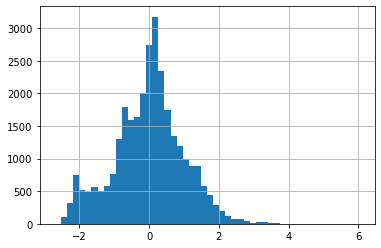

In [14]:
# Verify distribution is centered around 0 similar to normal distribution
tmp_df['fnlwgt_scaled'].hist(bins=50);

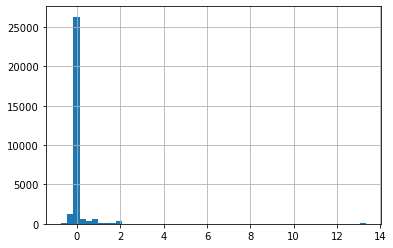

In [15]:
# Verify distribution is centered around 0 similar to normal distribution
tmp_df['capital_scaled'].hist(bins=50);

In [16]:
feature_names = [
    'age', 'workclass', 'education-num', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 
    'fnlwgt_scaled', 'capital_scaled'
]
print(f'n_features = {len(feature_names)}')


def extract_features(df, label='label', feature_names=feature_names):
    df['capital-diff'] = df['capital-gain'] - df['capital-loss']    # capital-gain and capital-loss can be combined

    # Convert categoricals to integer
    categorical_vars = [
        'workclass', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'native-country',
        'label'
    ]
    for col in categorical_vars:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes    # Will assign an integer for each category, assigning -1 to missing entries

    # fnlwgt and capital-diff need to be scaled
    df['fnlwgt_scaled'] = PowerTransformer(method='box-cox').fit_transform(df['fnlwgt'].values.reshape(-1, 1))    # strictly positive
    df['capital_scaled'] = StandardScaler().fit_transform(df['capital-diff'].values.reshape(-1, 1))
    
    return df[feature_names].to_numpy().T, df[label].to_numpy()

n_features = 12


In [17]:
X_train, Y_train = extract_features(census_train)
X_test, Y_test = extract_features(census_test)

In [18]:
np.save(f'{data_root}Census/census_X_train', X_train)
np.save(f'{data_root}Census/census_Y_train', Y_train)
np.save(f'{data_root}Census/census_X_test', X_test)
np.save(f'{data_root}Census/census_Y_test', Y_test)